In [28]:
import glob
import numpy
import pandas
import seaborn
import matplotlib.pyplot as plt
from tqdm import tqdm
import multiprocessing as mp
import os
from build import build_model
import coralme
plt.rcParams['svg.fonttype'] = 'none'


In [29]:
from IPython.display import display, HTML, Math, Markdown
display(HTML("<style>.container { width:95% !important; }</style>"))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
growth = pandas.read_csv("./datasets/all_growth_rates-context.csv",index_col=0)
taxonomy = pandas.read_csv("./taxonomy.txt",index_col=0,sep='\t')
taxonomy = taxonomy[taxonomy["Kingdom"]=="Bacteria"]
growth = growth.loc[[i for i in taxonomy.index]]#.fillna(0.)
# growth = growth[growth[[i for i in growth.columns if "high" in i]].all(axis=1)]

### Get ranks

In [31]:
rank = pandas.DataFrame()
for col in growth.columns:
    tmp = growth[col].sort_values()
    rank[col] = tmp.rank()
rank = rank.fillna(rank.shape[0])

In [32]:
df = pandas.concat([rank,taxonomy],axis=1)
df.head()

,base,low_iron,low_zinc,high_FA,high_carbs,high_prot,NCBI Taxonomy ID,Strain,Species,Genus,Family,Order,Class,Phylum,Kingdom
Corynebacterium_ulcerans_809,1.0,5.0,143.0,1.0,370.0,1.0,945711,Corynebacterium ulcerans 809,Corynebacterium ulcerans,Corynebacterium,Corynebacteriaceae,Corynebacteriales,Actinomycetia,Actinobacteria,Bacteria
Staphylococcus_lugdunensis_HKU09_01,2.0,19.0,1.0,2.0,1.0,3.0,698737,Staphylococcus lugdunensis HKU09-01,Staphylococcus lugdunensis,Staphylococcus,Staphylococcaceae,Bacillales,Bacilli,Firmicutes,Bacteria
Acinetobacter_lwoffii_WJ10621,3.0,3.0,495.0,3.0,2.0,5.0,1046625,Acinetobacter lwoffii WJ10621,Acinetobacter lwoffii,Acinetobacter,Moraxellaceae,Moraxellales,Gammaproteobacteria,Proteobacteria,Bacteria
Enterococcus_faecalis_TX1322,4.0,29.0,495.0,4.0,3.0,82.0,525278,Enterococcus faecalis TX1322,Enterococcus faecalis,Enterococcus,Enterococcaceae,Lactobacillales,Bacilli,Firmicutes,Bacteria
Streptococcus_australis_ATCC_700641,5.0,56.0,495.0,6.0,4.0,8.0,888833,Streptococcus australis ATCC 700641,Streptococcus australis,Streptococcus,Streptococcaceae,Lactobacillales,Bacilli,Firmicutes,Bacteria


### Mann-Whitney test

In [33]:
TAXA = "Genus"

In [34]:
from scipy.stats import mannwhitneyu
def mannwhitney(taxa, col,alt="greater"):
    taxa_df = df[df[TAXA] == taxa]
    y = taxa_df["base"].values
    x = taxa_df[col].values
    return mannwhitneyu(x,y , method="exact", alternative=alt)

### Mann-Whitney test for advantaged

In [35]:
dct = {}
for col in growth.drop("base",axis=1).columns:
    dct[col] = {}
    for taxa in df[TAXA].unique():
        U1, p = mannwhitney(taxa,col,alt="greater")
        dct[col][taxa] = p
adv = pandas.DataFrame.from_dict(dct)

/tmp/ipykernel_1461405/926906554.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds').copy()


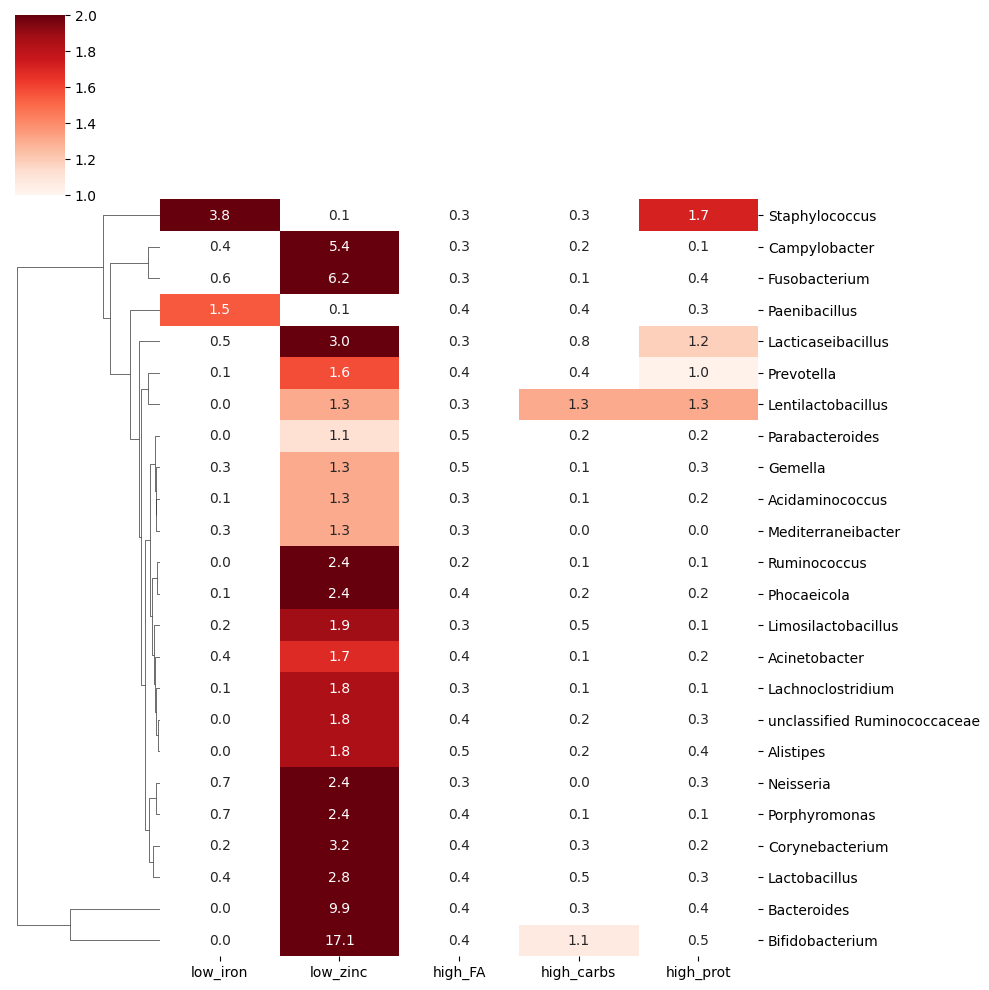

In [36]:
import seaborn as sns
cmap_df = adv.copy()
cmap_df = cmap_df[(cmap_df<0.1).any(axis=1)] # Only significant
cmap_df = -numpy.log10(cmap_df)
cmap = plt.cm.get_cmap('Reds').copy()
cmap.set_under('white')
vmin,vmax = (1.0,2)
cmap = sns.clustermap(cmap_df,
               row_cluster=True,
               col_cluster=False,
               vmin=vmin,
               vmax=vmax,
               annot=True,
               fmt=".1f",
               cmap=cmap,
               # annot_kws={'rotation': 90}
               # figsize=(1.0*cmap_df.shape[1],(0.3)*cmap_df.shape[0]),
               # cbar=False,
              )
labels = [i.get_text() for i in cmap.ax_heatmap.yaxis.get_majorticklabels()]

/tmp/ipykernel_1461405/1562577716.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds').copy()


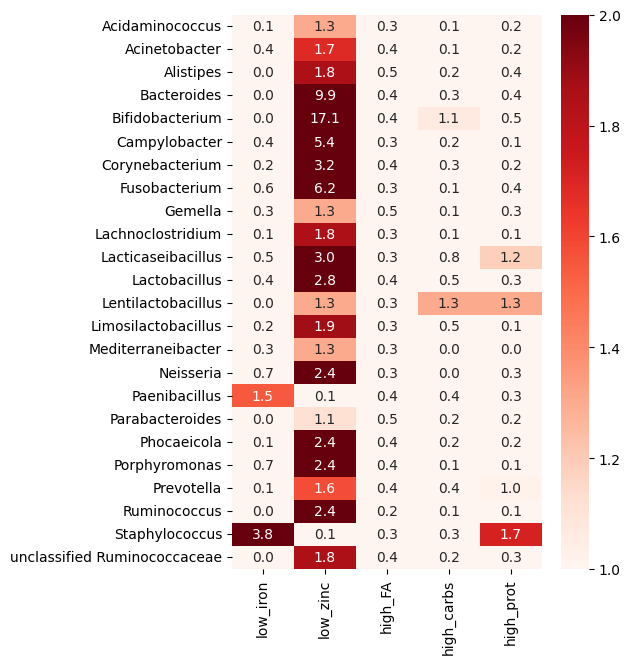

In [37]:
import seaborn as sns
fig,ax = plt.subplots(1,1, figsize=(1.0*cmap_df.shape[1],(0.3)*cmap_df.shape[0]))
cmap = plt.cm.get_cmap('Reds').copy()
# cmap.set_under('white')
cmap = sns.heatmap(cmap_df.loc[labels].sort_index(),
               vmin=vmin,
               vmax=vmax,
               annot=True,
               fmt=".1f",
               cmap=cmap,
               # annot_kws={'rotation': 90}
               # cbar=False,
              )
# cmap.ax_heatmap.set_xticklabels(cmap.ax_heatmap.get_xticklabels(), rotation=90)
# _=plt.setp(cmap.ax_heatmap.get_xticklabels(), rotation=80)

plt.savefig("./figures/4.3.3.MW-heatmap-greater-context.svg",format="SVG")

### Mann-Whitney test for disadvantaged

In [38]:
dct = {}
for col in growth.drop("base",axis=1).columns:
    dct[col] = {}
    for taxa in df[TAXA].unique():
        U1, p = mannwhitney(taxa,col,alt="less")
        dct[col][taxa] = p
dadv = pandas.DataFrame.from_dict(dct)

/tmp/ipykernel_1461405/266349042.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues').copy()


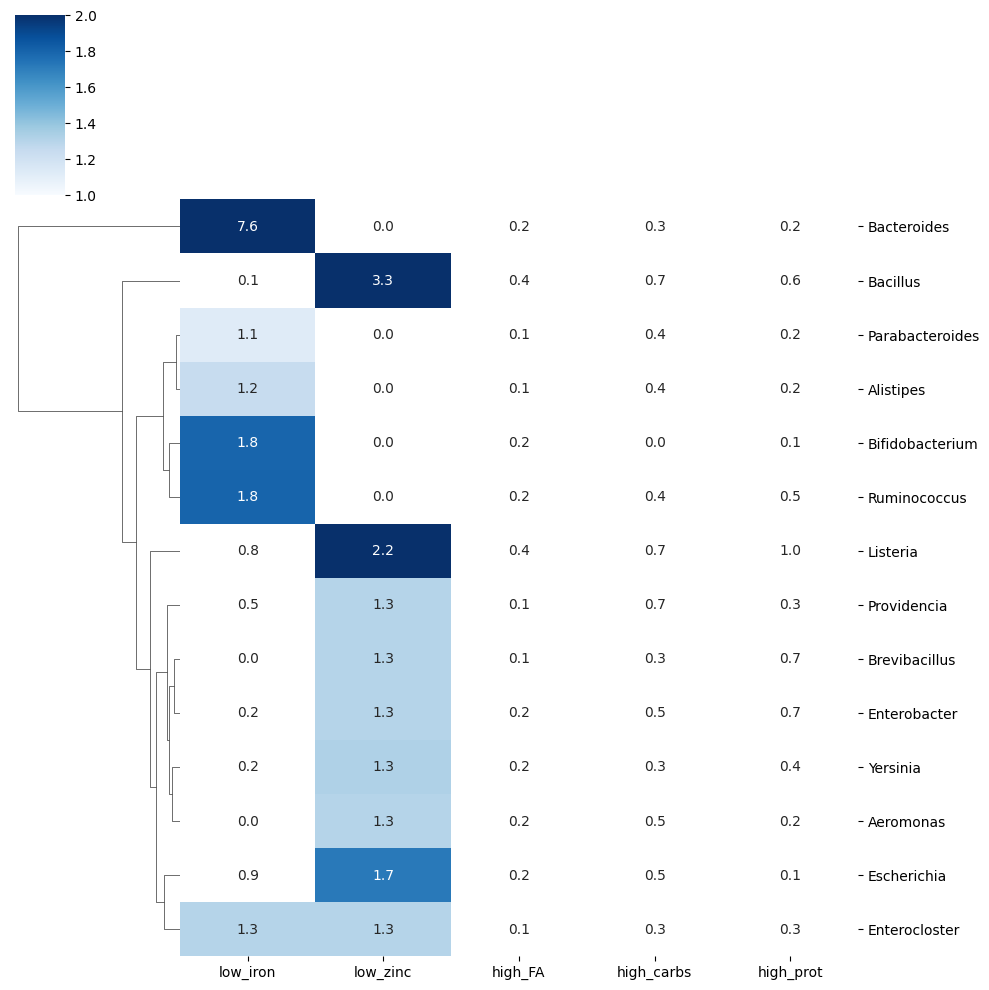

In [39]:
import seaborn as sns
cmap_df = dadv.copy()
cmap_df = cmap_df[(cmap_df<0.1).any(axis=1)] # Only significant
cmap_df = -numpy.log10(cmap_df)
cmap = plt.cm.get_cmap('Blues').copy()
cmap.set_under('white')
vmin,vmax = (1.0,2)
cmap = sns.clustermap(cmap_df,
               row_cluster=True,
               col_cluster=False,
               vmin=vmin,
               vmax=vmax,
               annot=True,
               fmt=".1f",
               cmap=cmap,
               # annot_kws={'rotation': 90}
               # figsize=(1.0*cmap_df.shape[1],(0.3)*cmap_df.shape[0]),
               # cbar=False,
              )
labels = [i.get_text() for i in cmap.ax_heatmap.yaxis.get_majorticklabels()]

/tmp/ipykernel_1461405/1801818972.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues').copy()


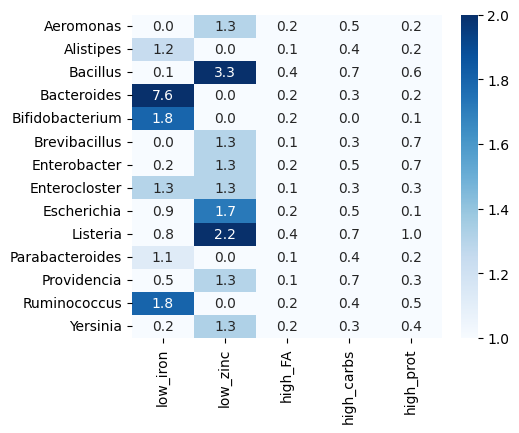

In [40]:
import seaborn as sns
fig,ax = plt.subplots(1,1, figsize=(1.0*cmap_df.shape[1],(0.3)*cmap_df.shape[0]))
cmap = plt.cm.get_cmap('Blues').copy()
# cmap.set_under('white')
cmap = sns.heatmap(cmap_df.loc[labels].sort_index(),
               vmin=vmin,
               vmax=vmax,
               annot=True,
               fmt=".1f",
               cmap=cmap,
               # annot_kws={'rotation': 90}
               # cbar=False,
              )
# cmap.ax_heatmap.set_xticklabels(cmap.ax_heatmap.get_xticklabels(), rotation=90)
# _=plt.setp(cmap.ax_heatmap.get_xticklabels(), rotation=80)

plt.savefig("./figures/4.3.3.MW-heatmap-less-context.svg",format="SVG")


### Save

In [27]:
adv.to_csv("./datasets/4.3.3.MW-greater-context.csv")
dadv.to_csv("./datasets/4.3.3.MW-less-context.csv")